# Conflict Analysis

Analyis to find areas with high conflict potential: Areas where wolf habitat suitability score is high and overlapping with alpine farm animal areas.

Objective: Identify High Conflict Zones (Wolf Habitat overlap with Livestock).  
Logic: Conflict = Habitat_Suitability * Livestock_Risk  

Livestock Risk is weighted: 
- Sheep Alpages (Code 49): High Risk (1.0)
- Other Pastures (Code 45-48): Medium Risk (0.6) - often cows or protected

In [21]:
import os
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from pathlib import Path

### Configuration

In [22]:
# --- CONFIGURATION ---
try:
    SCRIPT_DIR = Path(__file__).parent
except NameError:
    SCRIPT_DIR = Path.cwd()

PROJECT_ROOT = SCRIPT_DIR.parent
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Input Files
PATHS = {
    "habitat": OUTPUT_DIR / "habitat_suitability_final_wlc.tif", 
    "areal": DATA_DIR / "arealstatistik_2056.gpkg",
    "boundaries": DATA_DIR / "swissBOUNDARIES3D_1_5_LV95_LN02.gpkg",
    "water": OUTPUT_DIR / "water_mask_10m.tif"
}

# Output Files
CONFLICT_RASTER_PATH = OUTPUT_DIR / "conflict_zones_filtered.tif"

# --- PARAMETERS ---
PARAMS = {
    "grazing_buffer": 200,     # 200m buffer around points
    "habitat_threshold": 0.50, # Threshold: Only show conflict if Habitat Score > 0.5
                               # This removes pastures in settlements/urban areas.
    
    # Filter Arealstatistik Codes
    # 49: Schafalpen (High Vulnerability -> High Risk)
    "codes_sheep": [49],       
    
    # Other Pastures (Medium Vulnerability / Presence)
    # 43: Heimweiden (Siedlungsnah) -> Critical if overlapping with Wolf Habitat!
    # 44: Verbuschte Heimweiden
    # 45: Alpwiesen (Heu/Nachweide)
    # 46: Günstige Alpen (Oft Rinder -> Wehrhafter als Schafe)
    # 47: Verbuschte Alpen
    # 48: Versteinerte Alpen
    "codes_other": [43, 44, 45, 46, 47, 48] 
}

In [23]:
# --- FUNCTIONS ---
def get_graubuenden_boundary():
    try:
        gdf = gpd.read_file(PATHS["boundaries"], layer='TLM_KANTONSGEBIET')
        if 'NAME' in gdf.columns:
            gdf = gdf[gdf['NAME'].isin(['Graubünden', 'Grigioni', 'Grischun'])]
        elif 'kantonsnummer' in gdf.columns:
            gdf = gdf[gdf['kantonsnummer'] == 18]
        try:
            return gdf.geometry.union_all()
        except AttributeError:
            return gdf.geometry.unary_union
    except:
        return None

def read_raster(path):
    with rasterio.open(path) as src:
        return src.read(1), src.profile, src.nodata

def create_mask_from_codes(gdf, codes, buffer_dist, shape, transform):
    """Filters GDF by codes, buffers, and rasterizes."""
    subset = gdf[gdf['AS18_72'].isin(codes)]
    if subset.empty:
        return np.zeros(shape, dtype=rasterio.uint8)
    
    # Buffer
    zones = subset.buffer(buffer_dist)
    
    # Rasterize
    mask = features.rasterize(
        ((geom, 1) for geom in zones),
        out_shape=shape, transform=transform, 
        fill=0, default_value=1, dtype=rasterio.uint8
    )
    return mask

### Main Process

In [24]:
print("\n" + "="*40)
print("STARTING SMART CONFLICT ZONE VISUALIZATION")
print("="*40)

# 1. LOAD MAPS
if not PATHS["habitat"].exists():
    print("❌ Error: Habitat Map not found.")
    exit()

habitat, profile, nodata_hab = read_raster(PATHS["habitat"])
water, _, _ = read_raster(PATHS["water"])

# Mask NoData
habitat_masked = np.ma.masked_where(habitat == nodata_hab, habitat)
water_masked = np.ma.masked_where(water != 1, water)

# 2. PREPARE LIVESTOCK MASKS
print("2. Processing Livestock Data...")
gr_geom = get_graubuenden_boundary()
gdf_areal = gpd.read_file(PATHS["areal"], layer='arealstatistik_all', mask=gr_geom)

if 'AS18_72' in gdf_areal.columns:
    with rasterio.open(PATHS["habitat"]) as src:
        h_shape = src.shape
        h_transform = src.transform

    print(f"   -> Creating Sheep Mask (Code {PARAMS['codes_sheep']})...")
    mask_sheep = create_mask_from_codes(gdf_areal, PARAMS['codes_sheep'], PARAMS['grazing_buffer'], h_shape, h_transform)
    
    print(f"   -> Creating General Pasture Mask (Codes {PARAMS['codes_other']})...")
    mask_other = create_mask_from_codes(gdf_areal, PARAMS['codes_other'], PARAMS['grazing_buffer'], h_shape, h_transform)
else:
    print("❌ Error: AS18_72 column missing.")
    exit()

# 3. INTERSECTION WITH HABITAT SUITABILITY
print(f"3. Filtering Conflicts (Habitat Threshold > {PARAMS['habitat_threshold']})...")

# Logic: Conflict only exists if (Livestock IS Present) AND (Wolf IS Likely)
# We handle Sheep and Others separately for visualization

# A. High Priority Conflict (Sheep + Good Habitat)
conflict_sheep = np.where((mask_sheep == 1) & (habitat >= PARAMS['habitat_threshold']), 1, 0)

# B. Medium Priority Conflict (Other Pastures + Good Habitat)
conflict_other = np.where((mask_other == 1) & (habitat >= PARAMS['habitat_threshold']), 1, 0)

# Remove overlap from Medium (if it's already sheep, it's high priority)
conflict_other = np.where((conflict_other == 1) & (conflict_sheep == 0), 1, 0)

print(f"   -> Sheep Conflict Pixels: {np.sum(conflict_sheep)}")
print(f"   -> Other Conflict Pixels: {np.sum(conflict_other)}")


STARTING SMART CONFLICT ZONE VISUALIZATION
2. Processing Livestock Data...
   -> Creating Sheep Mask (Code [49])...
   -> Creating General Pasture Mask (Codes [43, 44, 45, 46, 47, 48])...
3. Filtering Conflicts (Habitat Threshold > 0.5)...
   -> Sheep Conflict Pixels: 4977044
   -> Other Conflict Pixels: 24820556


✅ Saved Smart Conflict Map to: c:\Workspace\ZHAW\5. Semester\GIS\project\output\conflict_zones_filtered.tif
4. Creating Visualization...


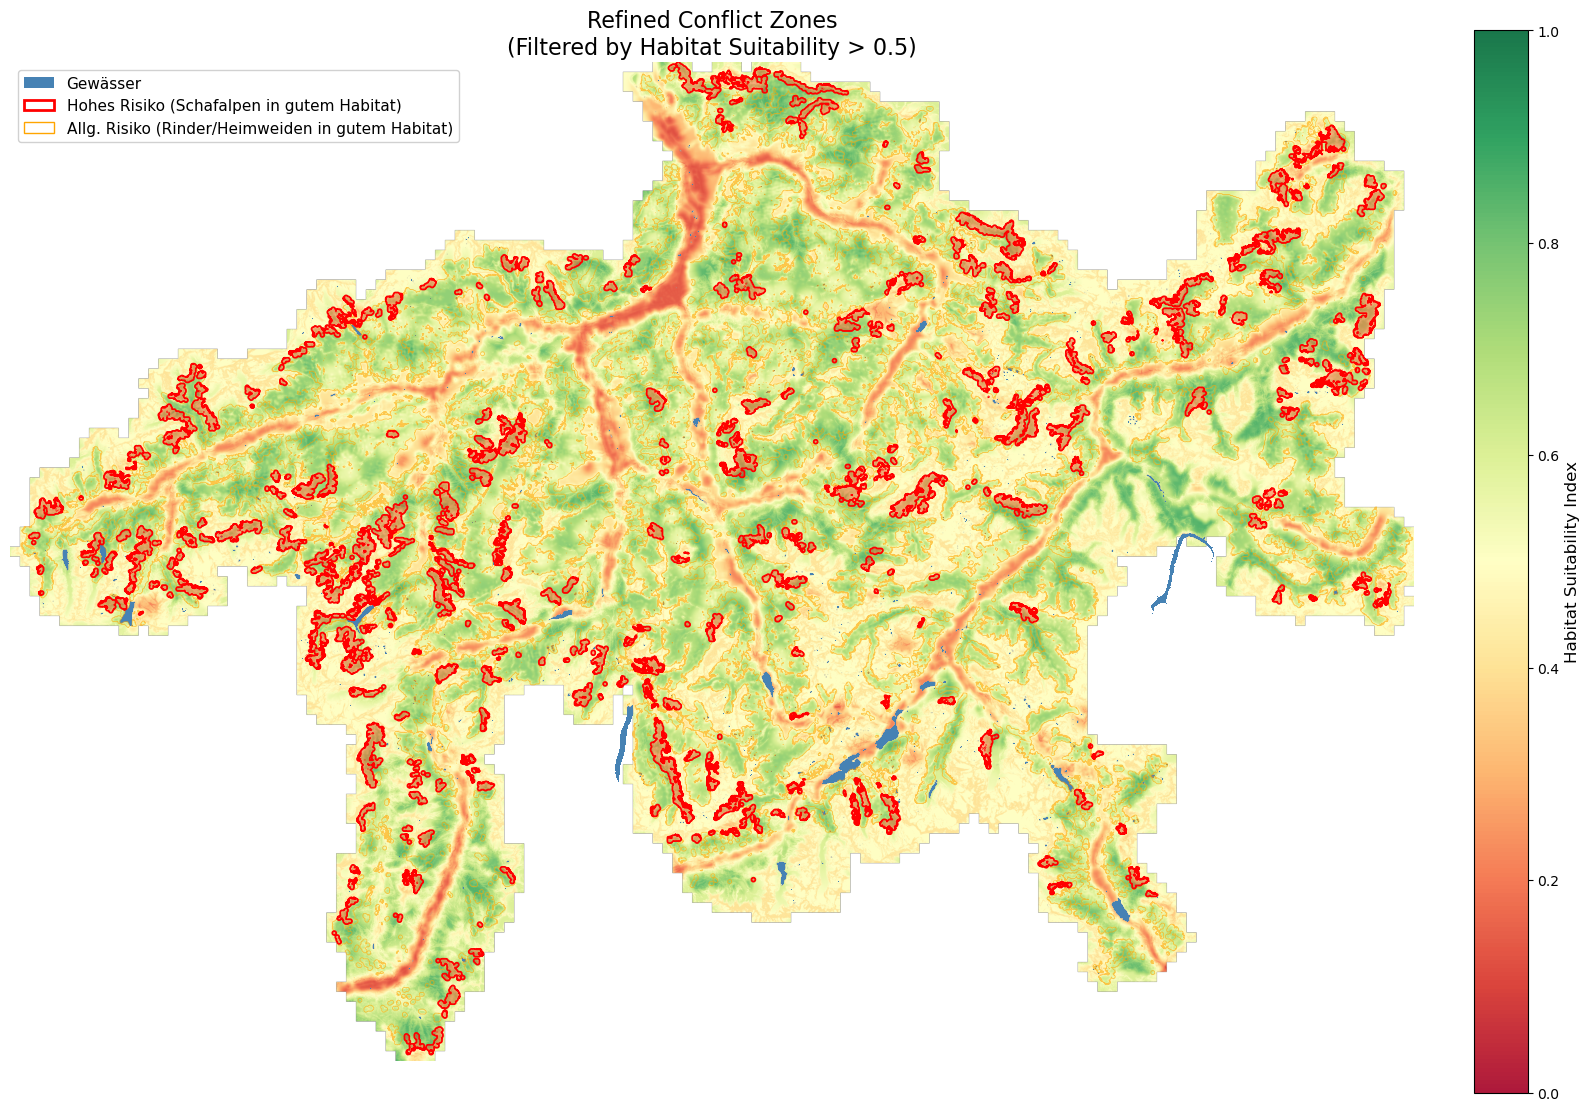

In [25]:
# 4. EXPORT
# We combine them into one raster for export: 2=Sheep, 1=Other, 0=None
final_conflict_raster = conflict_other + (conflict_sheep * 2)
profile.update(dtype=rasterio.uint8, count=1, nodata=0)
with rasterio.open(CONFLICT_RASTER_PATH, 'w', **profile) as dst:
    dst.write(final_conflict_raster.astype(rasterio.uint8), 1)
print(f"✅ Saved Smart Conflict Map to: {CONFLICT_RASTER_PATH}")


# 5. PLOTTING
print("4. Creating Visualization...")
fig, ax = plt.subplots(figsize=(16, 12))

# Layer 1: Habitat (Background)
im = ax.imshow(habitat_masked, cmap='RdYlGn', vmin=0, vmax=1, alpha=0.9)

# Layer 2: Water
ax.imshow(water_masked, cmap=ListedColormap(['#4682B4']), interpolation='none', alpha=1)

# Layer 3: Conflict Overlays
# A. Medium Conflict (Other Pastures) - Orange/Yellow Outline
mask_other_plot = np.ma.masked_where(conflict_other != 1, conflict_other)
ax.contour(conflict_other, levels=[0.5], colors='#FFA500', linewidths=0.6, alpha=0.6) # Subtle line

# B. HIGH CONFLICT (Sheep) - Red/Hatched Fill
mask_sheep_plot = np.ma.masked_where(conflict_sheep != 1, conflict_sheep)
# Distinctive Red Outline
ax.contour(conflict_sheep, levels=[0.5], colors='#FF0000', linewidths=1.2, alpha=1.0) 
# Semi-transparent red fill
ax.imshow(mask_sheep_plot, cmap=ListedColormap(['#FF0000']), alpha=0.3, interpolation='none')


# STYLING
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("Habitat Suitability Index", fontsize=12)

legend_elements = [
    Patch(facecolor='#4682B4', label='Gewässer'),
    Patch(facecolor='none', edgecolor='#FF0000', linewidth=2, label='Hohes Risiko (Schafalpen in gutem Habitat)'),
    Patch(edgecolor='#FFA500', facecolor='none', linewidth=1, label='Allg. Risiko (Rinder/Heimweiden in gutem Habitat)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True, facecolor='white', framealpha=0.9)

ax.set_title(f"Refined Conflict Zones\n(Filtered by Habitat Suitability > {PARAMS['habitat_threshold']})", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()